# 🗞️ News EDA & Filtering (2015–2020)

This notebook performs EDA and filters news headlines from:
- Huffington Post (JSON)
- Washington Post (CSV)
- Wall Street Journal (CSV)

**Steps:**
- Load and combine datasets
- Filter for dates between 2015 and 2020
- Visualize headline distribution
- Extract energy-related headlines
- Save filtered results

In [18]:
import pandas as pd
import json

# Load HuffPost JSON
with open('../data/raw/News_Category_Dataset_v3.json', 'r', encoding='utf-8') as f:
    data = [json.loads(line) for line in f]
huff_df = pd.DataFrame(data)
huff_df['source'] = 'HuffPost'
huff_df['date'] = pd.to_datetime(huff_df['date'], errors='coerce')
huff_df = huff_df[['headline', 'category', 'date', 'source']]

# Load Washington Post
wp_df = pd.read_csv('../data/raw/wp_hl.csv')
wp_df = wp_df.rename(columns={'headLine': 'headline', 'tags': 'category', 'lastmod': 'date'})
wp_df['source'] = 'Washington Post'
wp_df['date'] = pd.to_datetime(wp_df['date'], errors='coerce')
wp_df = wp_df[['headline', 'category', 'date', 'source']]

# Load Wall Street Journal
wsj_df = pd.read_csv('../data/raw/wsj_hl.csv')
wsj_df = wsj_df.rename(columns={'title': 'headline', 'section': 'category', 'time': 'date'})
wsj_df['source'] = 'WSJ'
wsj_df['date'] = pd.to_datetime(wsj_df['date'], errors='coerce')
wsj_df = wsj_df[['headline', 'category', 'date', 'source']]

# Combine all
news_df = pd.concat([huff_df, wp_df, wsj_df], ignore_index=True)

# ✅ Convert all dates to timezone-naive for consistency
news_df['date'] = pd.to_datetime(news_df['date'], utc=True, errors='coerce').dt.tz_localize(None)

# ✅ Drop rows without valid dates
news_df = news_df.dropna(subset=['date'])

# ✅ Filter to 2015–2020
news_df = news_df[(news_df['date'].dt.year >= 2015) & (news_df['date'].dt.year <= 2020)]

# ✅ Confirm result
print(news_df['source'].value_counts())

# Preview
news_df.head()


source
Washington Post    449954
WSJ                306516
HuffPost           107786
Name: count, dtype: int64


,headline,category,date,source
3464,Lindsey Graham Calls For Stand-Alone Vote On $...,POLITICS,2020-12-31,HuffPost
3465,24 Tweets About Cats Who Want To Watch The Wor...,COMEDY,2020-12-31,HuffPost
3466,Ken Jennings Apologizes For 'Unartful And Inse...,ENTERTAINMENT,2020-12-31,HuffPost
3467,Biden To Host Inauguration Eve Memorial To Liv...,POLITICS,2020-12-31,HuffPost
3468,"The Simple, Science-Backed Trick To Keeping Yo...",WELLNESS,2020-12-31,HuffPost


In [19]:
print(news_df['source'].value_counts())

source
Washington Post    449954
WSJ                306516
HuffPost           107786
Name: count, dtype: int64


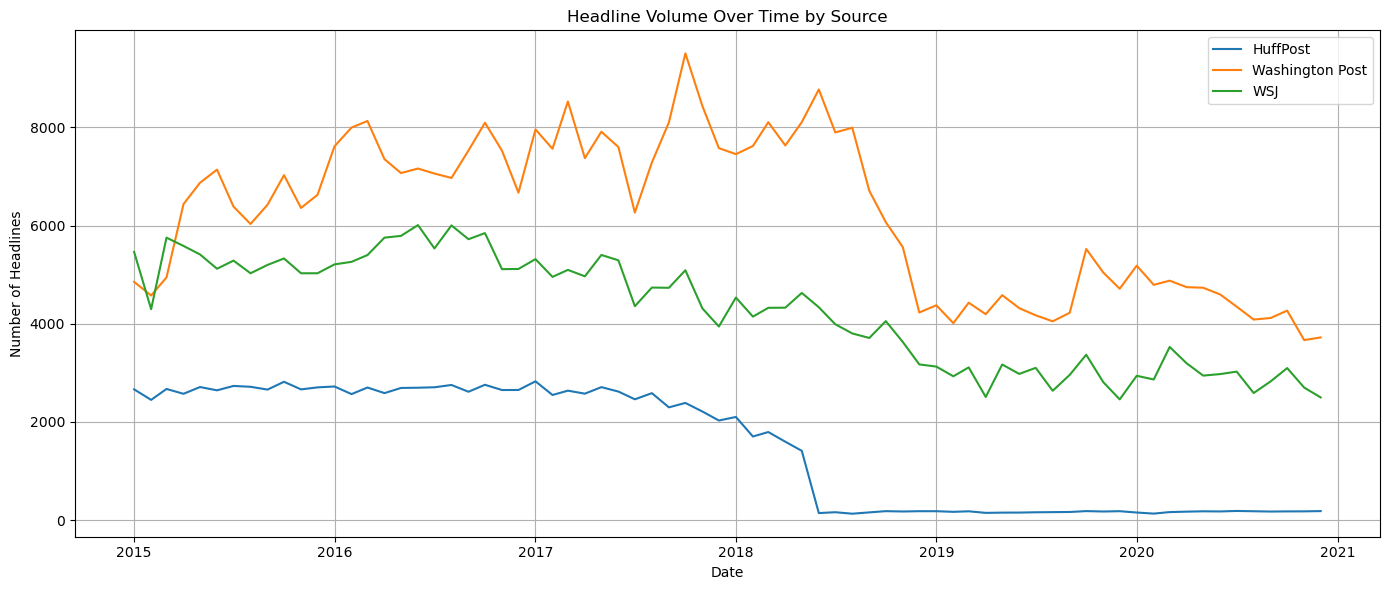

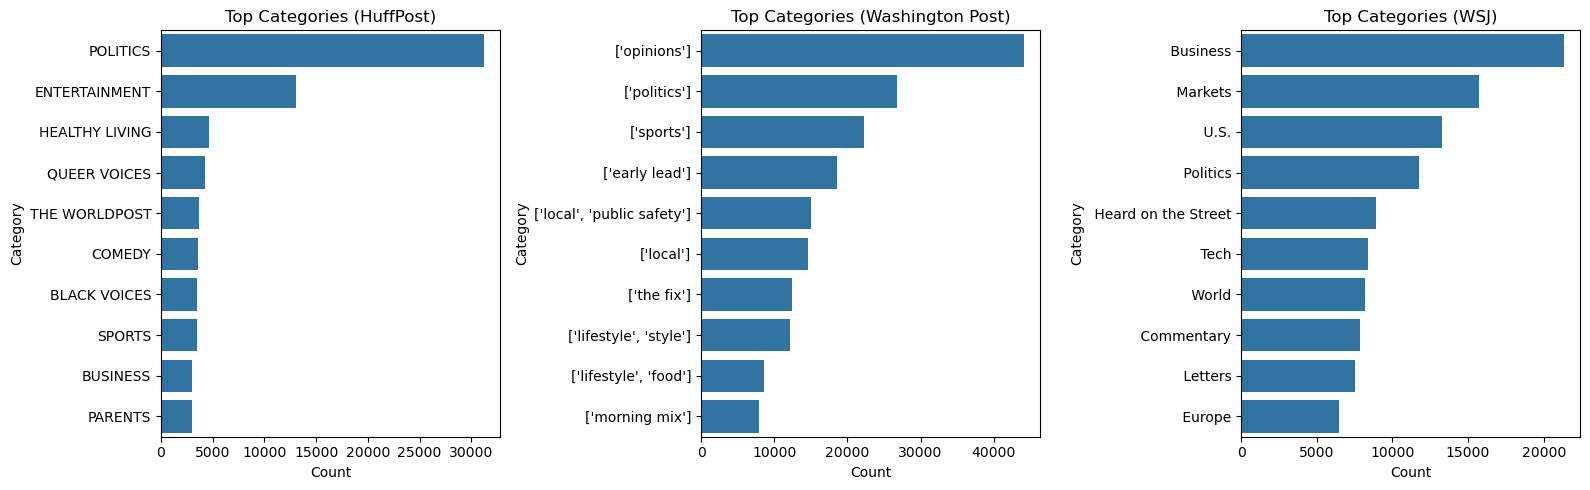

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Headline volume per source
plt.figure(figsize=(14, 6))
for source in news_df['source'].unique():
    monthly_counts = news_df[news_df['source'] == source]['date'].dt.to_period('M').value_counts().sort_index()
    plt.plot(monthly_counts.index.to_timestamp(), monthly_counts.values, label=source)

plt.title('Headline Volume Over Time by Source')
plt.xlabel('Date')
plt.ylabel('Number of Headlines')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Top categories per source (bar plot)
plt.figure(figsize=(16, 5))
for i, source in enumerate(news_df['source'].unique(), 1):
    plt.subplot(1, len(news_df['source'].unique()), i)
    top_cats = news_df[news_df['source'] == source]['category'].value_counts().head(10)
    sns.barplot(x=top_cats.values, y=top_cats.index)
    plt.title(f'Top Categories ({source})')
    plt.xlabel('Count')
    plt.ylabel('Category')

plt.tight_layout()
plt.show()


In [24]:
# Top 20 categories overall
top_categories = news_df['category'].value_counts().head(20)
print("🔝 Top 20 Categories (All Sources):")
print(top_categories)

# Optional: Save to CSV
# top_categories.to_csv('../data/processed/top_20_news_categories.csv')

# Top 10 categories per source
print("\n📊 Top Categories Per Source:")
for source in news_df['source'].unique():
    print(f"\n--- {source} ---")
    top = news_df[news_df['source'] == source]['category'].value_counts().head(30)
    print(top)


🔝 Top 20 Categories (All Sources):
category
['opinions']                  44121
POLITICS                      31198
['politics']                  26797
['sports']                    22234
 Business                     21331
['early lead']                18521
 Markets                      15717
['local', 'public safety']    14966
['local']                     14608
 U.S.                         13270
ENTERTAINMENT                 13087
['the fix']                   12489
['lifestyle', 'style']        12204
 Politics                     11754
 Heard on the Street           8930
['lifestyle', 'food']          8614
 Tech                          8383
 World                         8209
['morning mix']                7976
 Commentary                    7859
Name: count, dtype: int64

📊 Top Categories Per Source:

--- HuffPost ---
category
POLITICS          31198
ENTERTAINMENT     13087
HEALTHY LIVING     4686
QUEER VOICES       4217
THE WORLDPOST      3664
COMEDY             3582
BLACK VOI

Filtering by category

In [27]:
import ast

# Fix WP category format: convert stringified lists to plain strings
def extract_category(value):
    try:
        parsed = ast.literal_eval(value)
        if isinstance(parsed, list) and len(parsed) > 0:
            return parsed[0].strip().lower()
    except (ValueError, SyntaxError):
        return value.strip().lower()  # fallback
    return value

# Apply fix ONLY to Washington Post entries
wp_mask = news_df['source'] == 'Washington Post'
news_df.loc[wp_mask, 'category'] = news_df.loc[wp_mask, 'category'].astype(str).apply(extract_category)

In [28]:
# Re-normalize category for filtering
news_df['category_clean'] = news_df['category'].astype(str).str.strip()

# Define cleaned list again
keep_categories = [
    "politics", "the worldpost", "business", "world news", "impact", "worldpost", "science",
    "opinions", "early lead", "post politics", "capital weather gang", "worldviews", "world",
    "markets", "commentary", "europe", "central banks", "review & outlook", "earnings",
    "middle east", "economic data", "oil markets"
]

# Normalize all to lowercase
keep_categories = [cat.lower() for cat in keep_categories]

# Filter
filtered_news_df = news_df[news_df['category_clean'].str.lower().isin(keep_categories)].copy()
filtered_news_df.drop(columns='category_clean', inplace=True)

print(f"✅ Final filtered dataset: {len(filtered_news_df):,} rows")
print(filtered_news_df['source'].value_counts())


✅ Final filtered dataset: 281,983 rows
source
Washington Post    139739
WSJ                 97421
HuffPost            44823
Name: count, dtype: int64


In [31]:
keywords = ['energy', 'oil', 'gas', 'electricity', 'climate', 'fuel', 'renewable']
pattern = '|'.join(keywords)
energy_df = filtered_news_df[news_df['headline'].str.contains(pattern, case=False, na=False)]
print(f"⚡ Filtered {len(energy_df)} energy-related headlines")
energy_df.head()

⚡ Filtered 9388 energy-related headlines


C:\Users\iTECH\AppData\Local\Temp\ipykernel_12164\1524685352.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  energy_df = filtered_news_df[news_df['headline'].str.contains(pattern, case=False, na=False)]


,headline,category,date,source
3481,Child Labor In Palm Oil Industry Tied To Girl ...,BUSINESS,2020-12-29,HuffPost
3537,Ohio Quietly Passes A Bill That Could Bankrupt...,POLITICS,2020-12-19,HuffPost
3806,GOP Climate Denier Prevails In Critical Texas ...,POLITICS,2020-11-04,HuffPost
3917,Greta Thunberg Chides Amy Coney Barrett For He...,POLITICS,2020-10-15,HuffPost
3925,A Trump-Tied Law Firm ‘Played Both Sides Of Th...,POLITICS,2020-10-14,HuffPost


In [33]:
energy_df.to_csv('../data/processed/filtered_energy_news.csv', index=False)
print('✅ Saved filtered dataset to ../data/processed/filtered_energy_news.csv')

✅ Saved filtered dataset to ../data/processed/filtered_energy_news.csv


Now for analysis

In [34]:
!pip install transformers torch

   ---------------------------------------- 0.0/10.4 MB ? eta -:--:--
   ---------------------------------------- 0.0/10.4 MB ? eta -:--:--
   - -------------------------------------- 0.3/10.4 MB ? eta -:--:--
   -- ------------------------------------- 0.5/10.4 MB 882.6 kB/s eta 0:00:12
   -- ------------------------------------- 0.5/10.4 MB 882.6 kB/s eta 0:00:12
   --- ------------------------------------ 0.8/10.4 MB 860.9 kB/s eta 0:00:12
   ---- ----------------------------------- 1.0/10.4 MB 825.2 kB/s eta 0:00:12
   ---- ----------------------------------- 1.0/10.4 MB 825.2 kB/s eta 0:00:12
   ----- ---------------------------------- 1.3/10.4 MB 828.3 kB/s eta 0:00:11
   ------ --------------------------------- 1.6/10.4 MB 830.6 kB/s eta 0:00:11
   ------ --------------------------------- 1.6/10.4 MB 830.6 kB/s eta 0:00:11
   ------- -------------------------------- 1.8/10.4 MB 825.2 kB/s eta 0:00:11
   ------- -------------------------------- 1.8/10.4 MB 825.2 kB/s eta 0:00:11


In [36]:
import os
os.environ["TRANSFORMERS_NO_TF"] = "1"

from transformers import pipeline
import pandas as pd
from tqdm import tqdm

# Load filtered news
df = pd.read_csv('../data/processed/filtered_energy_news.csv')

# Init progress bar
tqdm.pandas()

# Init sentiment pipeline
sentiment_pipeline = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")

# Run prediction
df['sentiment'] = df['headline'].astype(str).progress_apply(lambda x: sentiment_pipeline(x)[0]['label'])
df['sentiment_score'] = df['headline'].astype(str).progress_apply(lambda x: sentiment_pipeline(x)[0]['score'])

# Save output
df.to_csv('../data/processed/filtered_energy_news_with_sentiment.csv', index=False)
print("✅ Sentiment scoring complete and saved.")


RuntimeError: Failed to import transformers.models.distilbert.modeling_tf_distilbert because of the following error (look up to see its traceback):
Your currently installed version of Keras is Keras 3, but this is not yet supported in Transformers. Please install the backwards-compatible tf-keras package with `pip install tf-keras`.